In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numpy import ma
from scipy.special import logsumexp
import os
import time
import json
import torch
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
from matplotlib import pyplot as plt
from matplotlib import cm

from kernels_w_guarantees import kernels
from kernels_w_guarantees import seq_tools
from kernels_w_guarantees.stats_funcs import bootstrap_mat, lin_reg_error

from strkernel.mismatch_kernel import MismatchKernel, preprocess

### Regression with kernels (Fig. 2)

The alignment kernels we consider will all be local alignment kernels.
In all cases we will consider $\mu = 1$, $\Delta\mu = 0.2$ and
$$k_s(b, b')=\sigma^{-1}|\mathcal{B}|\delta_b(b').$$
We will consider a alignment kernel with
$\log\sigma = 2\mu$
and another with $\log\sigma = 2\mu + 4$.
We will also consider an infinite spectrum kernel and a spectrum kernel that sums over substrings of length $3$.
Finally, we will use the normalized tilting of these kernels:
$$k^A(X, Y)=k(X, Y)/\sqrt{k(X, X)k(Y, Y)}.$$

In [2]:
alphabet_name = 'dna'
alphabet = seq_tools.alphabets_en[alphabet_name][:-1]
alphabet_size = len(alphabet)

max_seq_len = 8

In [3]:
mu = 1
delta_mu = 0.2

log_sigma = 2 * mu
sub_mat_w_d = np.exp(-log_sigma) * alphabet_size * torch.eye(alphabet_size)
kern_ali_w_d = kernels.get_ali_kernel(
    sub_mat=sub_mat_w_d,
    open_gap_score=-(mu+delta_mu), extend_gap_score=-mu,
    local_alignment=True,
    alphabet_size=alphabet_size, max_len=max_seq_len+1)

log_sigma = 2 * mu + 4
sub_mat_wo_d = np.exp(-log_sigma) * alphabet_size * torch.eye(alphabet_size)
kern_ali_wo_d = kernels.get_ali_kernel(
    sub_mat=sub_mat_wo_d,
    open_gap_score=-(mu+delta_mu), extend_gap_score=-mu,
    local_alignment=True,
    alphabet_size=alphabet_size, max_len=max_seq_len+1)

kern_spe_w_d = kernels.get_ali_kernel(
    sub_mat=torch.eye(alphabet_size),
    open_gap_score=-10000, extend_gap_score=0,
    local_alignment=True,
    alphabet_size=alphabet_size, max_len=max_seq_len+1)

kern_spe_wo_d = lambda x: kernels.kmer_kernel(x, k=3)

Now we load the data

In [4]:
# All DNA 8-mers in a shuffled order
seqs = np.load('data/tf_seqs.npy', allow_pickle=True)
# [n_seqs, 3] matrix of ESX1, HOXD13, and NKX2-5 binding for each sequence
# taken from doi: 10.1126/science.aad2257
vals = np.load('data/tf_vals.npy')
tf_names = ['ESX1', 'NKX2-5', 'HOXD13']

In [5]:
n_train_seqs = 2000 # 7000 was used in the paper
n_test_seqs = 200

train_seqs = seq_tools.get_ohe(seqs[:n_train_seqs])
test_seqs = seq_tools.get_ohe(seqs[-n_test_seqs:])

# Normalize and centre data
y_means = np.mean(np.log(vals+1), axis=0)
y_train = np.log(vals[:n_train_seqs]+1) - y_means[None, :]
y_test = np.log(vals[-n_test_seqs:]+1) - y_means[None, :]
y_var = np.average((y_test-np.average(y_test, axis=0)[None, :])**2, axis=0)

Next we calculate our kernel matrices

In [6]:
# compare all sequences
mat_ali_w_d = kern_ali_w_d(np.r_[train_seqs, test_seqs])
mat_ali_wo_d = kern_ali_wo_d(np.r_[train_seqs, test_seqs])
mat_spe_w_d = kern_spe_w_d(np.r_[train_seqs, test_seqs])
mat_spe_wo_d = kern_spe_wo_d(np.r_[train_seqs, test_seqs])
    
# Normalize matrices
def normalize_mat(mat):
    diag = np.diag(mat)
    return mat * (diag[:, None] * diag[None, :]) ** (-0.5)

mat_ali_w_d = normalize_mat(mat_ali_w_d)
mat_ali_wo_d = normalize_mat(mat_ali_wo_d)
mat_spe_w_d = normalize_mat(mat_spe_w_d)
mat_spe_wo_d = normalize_mat(mat_spe_wo_d)

# separate sets of sequences
mat_ali_w_d_xx = mat_ali_w_d[:n_train_seqs, :n_train_seqs]
mat_ali_w_d_yx = mat_ali_w_d[n_train_seqs:, :n_train_seqs]
mat_ali_wo_d_xx = mat_ali_wo_d[:n_train_seqs, :n_train_seqs]
mat_ali_wo_d_yx = mat_ali_wo_d[n_train_seqs:, :n_train_seqs]
mat_spe_w_d_xx = mat_spe_w_d[:n_train_seqs, :n_train_seqs]
mat_spe_w_d_yx = mat_spe_w_d[n_train_seqs:, :n_train_seqs]
mat_spe_wo_d_xx = mat_spe_wo_d[:n_train_seqs, :n_train_seqs]
mat_spe_wo_d_yx = mat_spe_wo_d[n_train_seqs:, :n_train_seqs]

/n/groups/marks/users/alan/ksds-for-variable-length-seqs/sample_code_JMLR2023/kernels_w_guarantees/kernels.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  out[i*batch_size : (i+1)*batch_size] = f(x_batch)


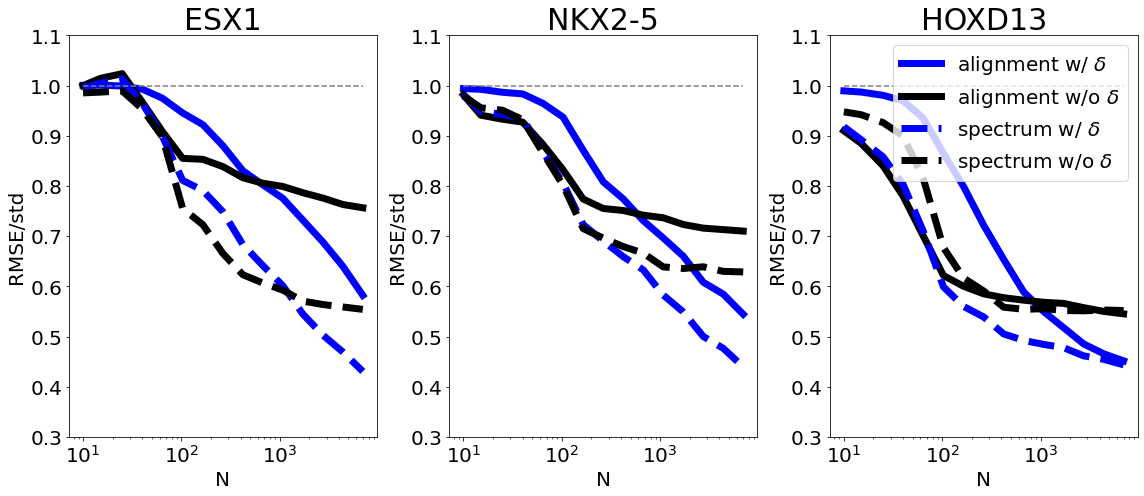

In [7]:
# now plot results
fig, axs = plt.subplots(1, 3, figsize=[16, 7])
models = [(mat_ali_w_d_xx, mat_ali_w_d_yx),
          (mat_ali_wo_d_xx, mat_ali_wo_d_yx),
          (mat_spe_w_d_xx, mat_spe_w_d_yx),
          (mat_spe_wo_d_xx, mat_spe_wo_d_yx)]
labels = ['alignment w/ $\delta$', 'alignment w/o $\delta$',
          'spectrum w/ $\delta$', 'spectrum w/o $\delta$']
colors = ['blue', 'black',] * 2
lss = ['-'] * 2 + ['--'] * 2

ns = np.logspace(np.log10(10), np.log10(n_train_seqs), 15).astype(int)

for ax, tf_name, y_train_set, y_test_set, var in zip(axs, tf_names, y_train.T, y_test.T, y_var):
    regularize = 2
    mses = np.zeros([len(models), len(ns)])
    for i, n in enumerate(ns):
        for j, (k_xx, k_yx) in enumerate(models):
            error = lin_reg_error(k_yx[:, :n], k_xx[:n, :n],
                                  y_train_set[:n], y_test_set,
                                  regularize=regularize)
            mses[j, i] = error

    min_y = 1
    for mse, label, color, ls in zip(mses, labels, colors, lss):
        ax.semilogx(ns, np.sqrt(mse/var),
                     label=label, color=color, lw=7, ls=ls)
    ax.semilogx(ns, np.ones(len(ns)), color='grey', ls='--')
    ax.set_xlabel("N", fontsize=20)
    ax.set_ylabel("RMSE/std", fontsize=20)
    ax.set_ylim(0.3, 1.1)
    ax.tick_params(labelsize=20)
    ax.set_title(tf_name, fontsize=30)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()
plt.close()

One can see that regressing with kernels with delta functions allows one to better fit the function one is learning.

### Distinguishing distributions with kernels (Fig. 3)

We will consider the same kernels as before. Although we use k = 2 for the spectrum kernel instead of the k = 3 used in the paper for memory concerns.

In [72]:
alphabet_name = 'prot'
alphabet = seq_tools.alphabets_en[alphabet_name][:-1]
alphabet_size = len(alphabet)

max_seq_len = 30

In [73]:
mu = 1
delta_mu = 0.2

log_sigma = 2 * mu
sub_mat_w_d = np.exp(-log_sigma) * alphabet_size * torch.eye(alphabet_size)
kern_ali_w_d = kernels.get_ali_kernel(
    sub_mat=sub_mat_w_d,
    open_gap_score=-(mu+delta_mu), extend_gap_score=-mu,
    local_alignment=True,
    alphabet_size=alphabet_size, max_len=max_seq_len+1)

log_sigma = 2 * mu + 4
sub_mat_wo_d = np.exp(-log_sigma) * alphabet_size * torch.eye(alphabet_size)
kern_ali_wo_d = kernels.get_ali_kernel(
    sub_mat=sub_mat_wo_d,
    open_gap_score=-(mu+delta_mu), extend_gap_score=-mu,
    local_alignment=True,
    alphabet_size=alphabet_size, max_len=max_seq_len+1)

kern_spe_w_d = kernels.get_ali_kernel(
    sub_mat=torch.eye(alphabet_size),
    open_gap_score=-10000, extend_gap_score=0,
    local_alignment=True,
    alphabet_size=alphabet_size, max_len=max_seq_len+1)

# this implementation uses less memory when the alphabet is larger
kern_spe_wo_d = lambda seqs: MismatchKernel(l=alphabet_size, k=3, m=0).get_kernel(
    seq_tools.get_inds(seqs, alphabet_name=alphabet_name), normalize=False).kernel

In [78]:
repetitions = 25
N = 80

# sequences are donors 1 and 4 from 
#10x Genomics. A new way of exploring immunity: linking highly multiplexed antigen
# recognition to immune repertoire and phenotype.
seqs_1 = np.load('data/cdr3_donor_2.npy')
np.random.shuffle(seqs_1)
seqs_1 = seqs_1[:repetitions * N].reshape([repetitions, N])
seqs_2 = np.load('data/cdr3_donor_3.npy')
np.random.shuffle(seqs_2)
seqs_2 = seqs_2[:repetitions * N].reshape([repetitions, N])

all_ohe = seq_tools.get_ohe(np.r_[seqs_1, seqs_2], alphabet_name=alphabet_name)
seqs_1 = all_ohe[:repetitions]
seqs_2 = all_ohe[repetitions:]

In [79]:
def normalize_mat(mat):
    diag = np.diag(mat)
    return mat * (diag[:, None] * diag[None, :]) ** (-0.5)
    
# We calculate the kernel matrices
k_ali_w_d_xx_mats = []
k_ali_w_d_xy_mats = []
k_ali_w_d_yy_mats = []
k_ali_wo_d_xx_mats = []
k_ali_wo_d_xy_mats = []
k_ali_wo_d_yy_mats = []
k_spe_w_d_xx_mats = []
k_spe_w_d_xy_mats = []
k_spe_w_d_yy_mats = []
k_spe_wo_d_xx_mats = []
k_spe_wo_d_xy_mats = []
k_spe_wo_d_yy_mats = []
for r, (seqs_1_rep, seqs_2_rep) in enumerate(zip(seqs_1, seqs_2)):
    print("Processing rep", r, '/', repetitions)
    # compare all sequences
    mat_ali_w_d = kern_ali_w_d(np.r_[seqs_1_rep, seqs_2_rep])
    mat_ali_wo_d = kern_ali_wo_d(np.r_[seqs_1_rep, seqs_2_rep])
    mat_spe_w_d = kern_spe_w_d(np.r_[seqs_1_rep, seqs_2_rep])
    mat_spe_wo_d = kern_spe_wo_d(np.r_[seqs_1_rep, seqs_2_rep])

    # Normalize matrices
    mat_ali_w_d = normalize_mat(mat_ali_w_d)
    mat_ali_wo_d = normalize_mat(mat_ali_wo_d)
    mat_spe_w_d = normalize_mat(mat_spe_w_d)
    mat_spe_wo_d = normalize_mat(mat_spe_wo_d)
    
    # store mats
    k_ali_w_d_xx_mats.append(mat_ali_w_d[:N, :N])
    k_ali_w_d_xy_mats.append(mat_ali_w_d[:N, N:])
    k_ali_w_d_yy_mats.append(mat_ali_w_d[N:, N:])
    k_ali_wo_d_xx_mats.append(mat_ali_wo_d[:N, :N])
    k_ali_wo_d_xy_mats.append(mat_ali_wo_d[:N, N:])
    k_ali_wo_d_yy_mats.append(mat_ali_wo_d[N:, N:])
    k_spe_w_d_xx_mats.append(mat_spe_w_d[:N, :N])
    k_spe_w_d_xy_mats.append(mat_spe_w_d[:N, N:])
    k_spe_w_d_yy_mats.append(mat_spe_w_d[N:, N:])
    k_spe_wo_d_xx_mats.append(mat_spe_wo_d[:N, :N])
    k_spe_wo_d_xy_mats.append(mat_spe_wo_d[:N, N:])
    k_spe_wo_d_yy_mats.append(mat_spe_wo_d[N:, N:])

Processing rep 0 / 25
Processing rep 1 / 25
Processing rep 2 / 25
Processing rep 3 / 25
Processing rep 4 / 25
Processing rep 5 / 25
Processing rep 6 / 25
Processing rep 7 / 25
Processing rep 8 / 25
Processing rep 9 / 25
Processing rep 10 / 25
Processing rep 11 / 25
Processing rep 12 / 25
Processing rep 13 / 25
Processing rep 14 / 25
Processing rep 15 / 25
Processing rep 16 / 25
Processing rep 17 / 25
Processing rep 18 / 25
Processing rep 19 / 25
Processing rep 20 / 25
Processing rep 21 / 25
Processing rep 22 / 25
Processing rep 23 / 25
Processing rep 24 / 25


In [82]:
# Calculate p values using a wild bootstrap on the MMD statistic
ns = np.logspace(np.log10(7), np.log10(N), 20).astype(int)
p_vals_ali_w_d = np.empty([repetitions, len(ns)])
p_vals_ali_wo_d = np.empty([repetitions, len(ns)])
p_vals_spe_w_d = np.empty([repetitions, len(ns)])
p_vals_spe_wo_d = np.empty([repetitions, len(ns)])
for r in range(repetitions):
    print("Processing rep", r, '/', repetitions)
    for i, n in enumerate(ns):
        mmd_ali_w_d_mat = (k_ali_w_d_xx_mats[r][:n, :n]
                       - k_ali_w_d_xy_mats[r][:n, :n]
                       - k_ali_w_d_xy_mats[r][:n, :n].T
                       + k_ali_w_d_yy_mats[r][:n, :n])
        p_vals_ali_w_d[r, i] = np.average(
            ma.masked_array(mmd_ali_w_d_mat, np.eye(n)).mean()
            < np.array(bootstrap_mat(mmd_ali_w_d_mat)))
        
        mmd_ali_wo_d_mat = (k_ali_wo_d_xx_mats[r][:n, :n]
                       - k_ali_wo_d_xy_mats[r][:n, :n]
                       - k_ali_wo_d_xy_mats[r][:n, :n].T
                       + k_ali_wo_d_yy_mats[r][:n, :n])
        p_vals_ali_wo_d[r, i] = np.average(
            ma.masked_array(mmd_ali_wo_d_mat, np.eye(n)).mean()
            < np.array(bootstrap_mat(mmd_ali_wo_d_mat)))
        
        mmd_spe_w_d_mat = (k_spe_w_d_xx_mats[r][:n, :n]
                       - k_spe_w_d_xy_mats[r][:n, :n]
                       - k_spe_w_d_xy_mats[r][:n, :n].T
                       + k_spe_w_d_yy_mats[r][:n, :n])
        p_vals_spe_w_d[r, i] = np.average(
            ma.masked_array(mmd_spe_w_d_mat, np.eye(n)).mean()
            < np.array(bootstrap_mat(mmd_spe_w_d_mat)))
        
        mmd_spe_wo_d_mat = (k_spe_wo_d_xx_mats[r][:n, :n]
                       - k_spe_wo_d_xy_mats[r][:n, :n]
                       - k_spe_wo_d_xy_mats[r][:n, :n].T
                       + k_spe_wo_d_yy_mats[r][:n, :n])
        p_vals_spe_wo_d[r, i] = np.average(
            ma.masked_array(mmd_spe_wo_d_mat, np.eye(n)).mean()
            < np.array(bootstrap_mat(mmd_spe_wo_d_mat)))

Processing rep 0 / 25
Processing rep 1 / 25
Processing rep 2 / 25
Processing rep 3 / 25
Processing rep 4 / 25
Processing rep 5 / 25
Processing rep 6 / 25
Processing rep 7 / 25
Processing rep 8 / 25
Processing rep 9 / 25
Processing rep 10 / 25
Processing rep 11 / 25
Processing rep 12 / 25
Processing rep 13 / 25
Processing rep 14 / 25
Processing rep 15 / 25
Processing rep 16 / 25
Processing rep 17 / 25
Processing rep 18 / 25
Processing rep 19 / 25
Processing rep 20 / 25
Processing rep 21 / 25
Processing rep 22 / 25
Processing rep 23 / 25
Processing rep 24 / 25


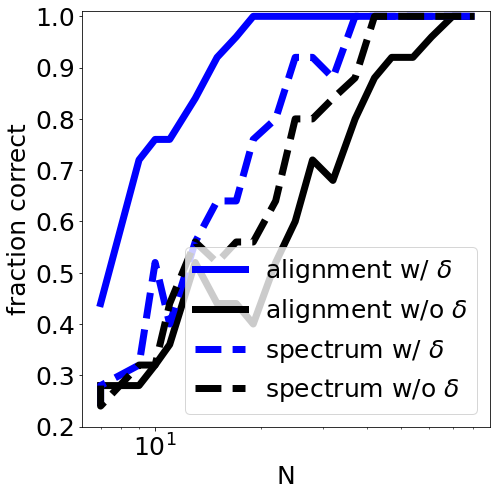

In [87]:
# plot results

plt.figure(figsize=[7, 7])
plt.semilogx(ns, np.average(p_vals_ali_w_d<0.05, axis=0),
             label='alignment w/ $\delta$', color='blue', lw=7)
plt.semilogx(ns, np.average(p_vals_ali_wo_d<0.05, axis=0),
             label='alignment w/o $\delta$', color='black', lw=7)
plt.semilogx(ns, np.average(p_vals_spe_w_d<0.05, axis=0),
             label='spectrum w/ $\delta$', color='blue', lw=7, ls='--')
plt.semilogx(ns, np.average(p_vals_spe_wo_d<0.05, axis=0),
             label='spectrum w/o $\delta$', color='black', lw=7, ls='--')
plt.xlabel("N", fontsize=25)
plt.ylabel("fraction correct", fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(0.2, 1.01)
plt.legend(fontsize=25)
plt.tight_layout()
plt.show()
plt.close()